In [23]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
from PIL import Image
import time
from graph_tool.all import *

# Data information:

* rasterwgs84 is 976, 1760, main folder is ca 2500x3000

np.mgrid might be useful

In [2]:
path_files = "/Users/ninawiedemann/Downloads/tif_ras_buf"

In [3]:
def read_in_tifs(path):
    files = os.listdir(path)
    tif_list = []
    file_list = []
    for f in files:
        if f[-3:]=="tif":
            img = Image.open(os.path.join(path,f))
            tif_list.append(np.array(img))
            file_list.append(f[:-4])
    tif_arr = np.array(tif_list)
    tif_arr = tif_arr/255.
    print("shape of tif array:", tif_arr.shape)
    return tif_arr, file_list

shape of tif array: (71, 2627, 3022)


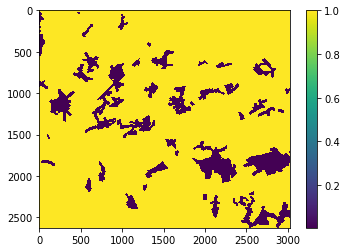

In [4]:
tifs, files = read_in_tifs(path_files)
plt.imshow(tifs[8,:,:])
plt.colorbar()
plt.show()

### Hard constraints

### Corridor

In [5]:
import rasterio

def get_corridor(path, fn = "Corridor_BE.tif"):
    with rasterio.open(os.path.join(path,fn), 'r') as ds:
        arr = ds.read() 
    corr_img = Image.fromarray(arr[0])
    corr_resized = corr_img.resize((3022, 2627),resample=Image.BILINEAR)
    corridor = (np.array(corr_resized)<9900).astype(int)
    # plt.imshow(corridor)
    # plt.colorbar()
    # plt.show()
    return corridor

In [6]:
corridor = get_corridor(os.path.join(path_files, "corridor"))

### Other hard constraints

In [7]:
hard_cons_path = os.path.join(path_files, "hard_constraints")
hard_cons_arr, files = read_in_tifs(hard_cons_path)
# add corridor
hard_cons_arr = np.concatenate((hard_cons_arr, np.expand_dims(corridor, axis=0)), axis=0)
print(hard_cons_arr.shape)

shape of tif array: (3, 2627, 3022)
(4, 2627, 3022)


In [8]:
# logical and between all hard constraints
hard_constraints = np.all(hard_cons_arr.astype(int), axis=0)

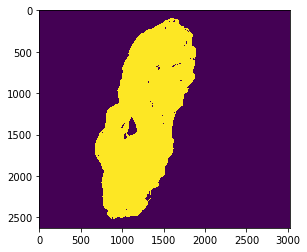

In [9]:
plt.imshow(hard_constraints)
plt.show()

### Sum tifs

In [10]:
summed = np.sum(tifs, axis=0)

In [11]:
summed.shape

(2627, 3022)

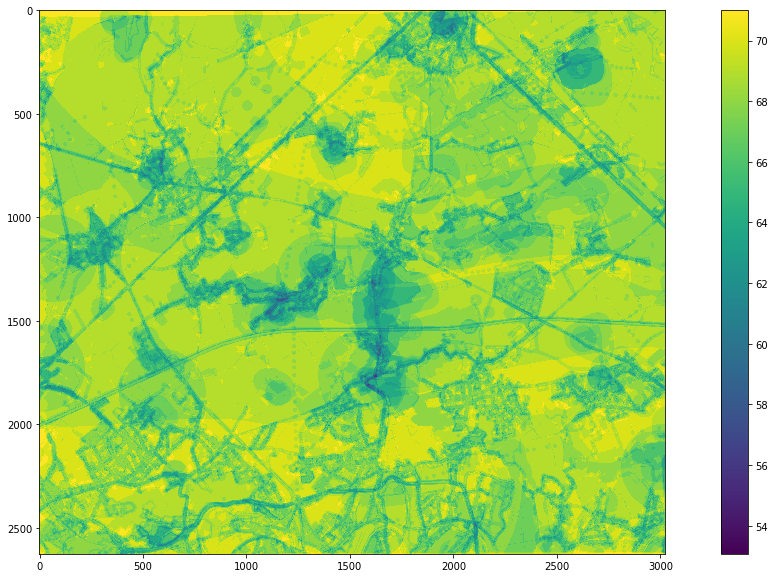

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(summed)
plt.colorbar()
plt.show()

### Define circle coordinates

In [13]:
def get_donut(radius_low, radius_high):
    img_size = radius_high + 10
    # xx and yy are 200x200 tables containing the x and y coordinates as values
    # mgrid is a mesh creation helper
    xx, yy = np.mgrid[-img_size:img_size, -img_size:img_size]
    # circle equation
    circle = (xx) ** 2 + (yy) ** 2
    # donuts contains 1's and 0's organized in a donut shape
    # you apply 2 thresholds on circle to define the shape
    donut = np.logical_and(circle < (radius_high**2), circle > (radius_low**2))
    pos_x, pos_y = np.where(donut>0)
    return pos_x-img_size, pos_y-img_size

def get_half_donut(radius_low, radius_high):
    pos_x, pos_y = get_donut(radius_low, radius_high)
    new_tuples = []
    for i, j in zip(pos_x, pos_y):
        if i>0 or i==0 and j>0:
            new_tuples.append((i,j))
    return new_tuples

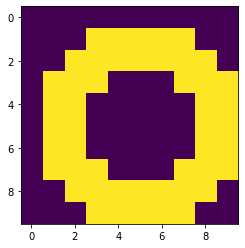

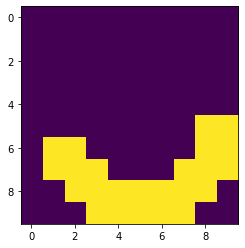

In [14]:
# example:
upper = 5
pos_x, pos_y = get_donut(2.5,upper)

# new donut
new_tuples = []
for i, j in zip(pos_x, pos_y):
    if i>0 or i==0 and j>0:
        new_tuples.append((i,j))

# whole donut
ar = np.zeros((2*upper,2*upper))
for i in range(len(pos_x)):
    ar[pos_x[i]+upper, pos_y[i]+upper]=1
plt.imshow(ar)
plt.show()

# modified donut
ar = np.zeros((2*upper,2*upper))
for tup in new_tuples:
    ar[tup[0]+upper, tup[1]+upper]=1
plt.imshow(ar)
plt.show()

### Scale down instance

In [15]:
def reduce_instance(summed, square):
    x_len,y_len = summed.shape
    new_img = np.zeros((x_len//square, y_len//square))
    for i in range(x_len//square):
        for j in range(y_len//square):
            patch = summed[i*square:(i+1)*square, j*square:(j+1)*square]
            new_img[i,j] = np.mean(patch)
    return new_img

In [37]:
instance = reduce_instance(summed, 1)
instance_norm = (instance-np.min(instance))/(np.max(instance)-np.min(instance))

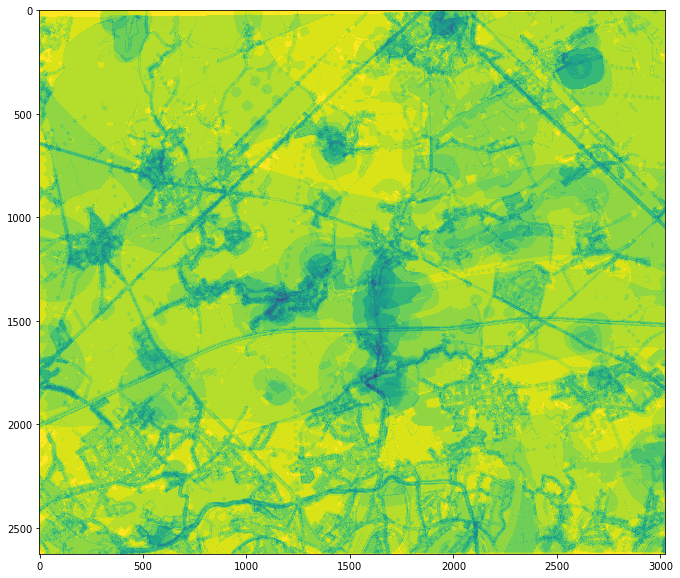

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(instance_norm)
# plt.colorbar()
plt.show()

In [39]:
instance_corr = reduce_instance(hard_constraints, 1)

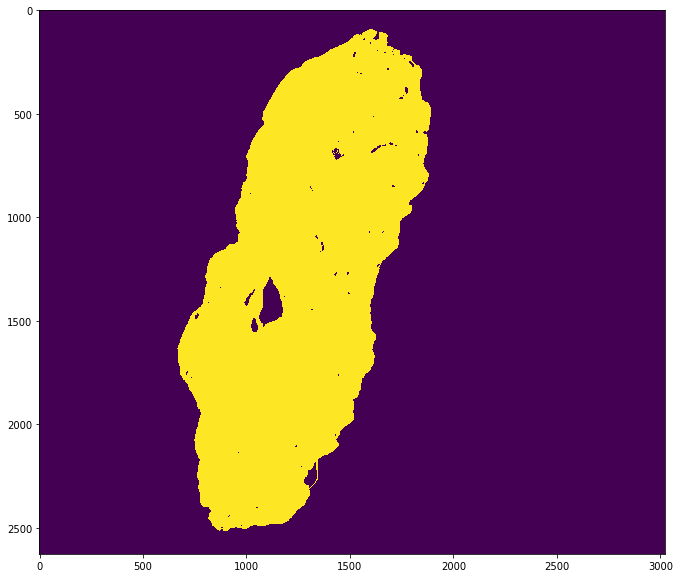

In [40]:
plt.figure(figsize=(20,10))
plt.imshow(instance_corr)
# plt.colorbar()
plt.show()

In [41]:
instance_norm.shape

(2627, 3022)

## Networkx graph

In [207]:
def pos2node(pos, length):
    return pos[0]*length + pos[1]
def node2pos(node, length):
    j = node%length # rest
    i = node//length
    return i,j

### Define nodes

In [208]:
pos_x, pos_y = get_donut(2.5,5)

In [209]:
# node_list = ["{},{}".format(str(i), str(i)) for i in range(10)] # with strings
x_len, y_len = instance_norm.shape
print(x_len, y_len)
node_list = [(pos2node((i,j), y_len),{"pos":(i,j)}) for i in range(x_len) for j in range(y_len) if instance_corr[i,j]]
# assert len(np.unique([n[0] for n in node_list]))==x_len*y_len

525 604


In [210]:
node_list_wo_attr = [n[0] for n in node_list]

### Build edge list

In [137]:
import time

In [211]:
tic = time.time()
inds_x, inds_y = np.where(instance_corr>0)
donut_tuples = get_half_donut(2.5,5)
edge_list = []

for i, j in zip(inds_x, inds_y):
    weight_node = 1-instance_norm[i,j]
    node_name = pos2node((i,j), y_len)
    for (x,y) in donut_tuples:
        new_x = i+x
        new_y = j+y
        if new_x>=0 and new_x<x_len and new_y>=0 and new_y<y_len and instance_corr[new_x,new_y]: # inside corridor
            weight = 1-instance_norm[new_x, new_y]+weight_node
            edge_list.append((node_name, pos2node((new_x,new_y), y_len), {"weight": round(weight,1)}))
            
print(time.time()-tic)

21.966463804244995


In [212]:
print(len(edge_list))

1639820


### Add edges and nodes to graph

In [ ]:
g = nx.Graph()
g.add_nodes_from(node_list)
g.add_edges_from(edge_list)

### Plot the graph with edge attributes etc

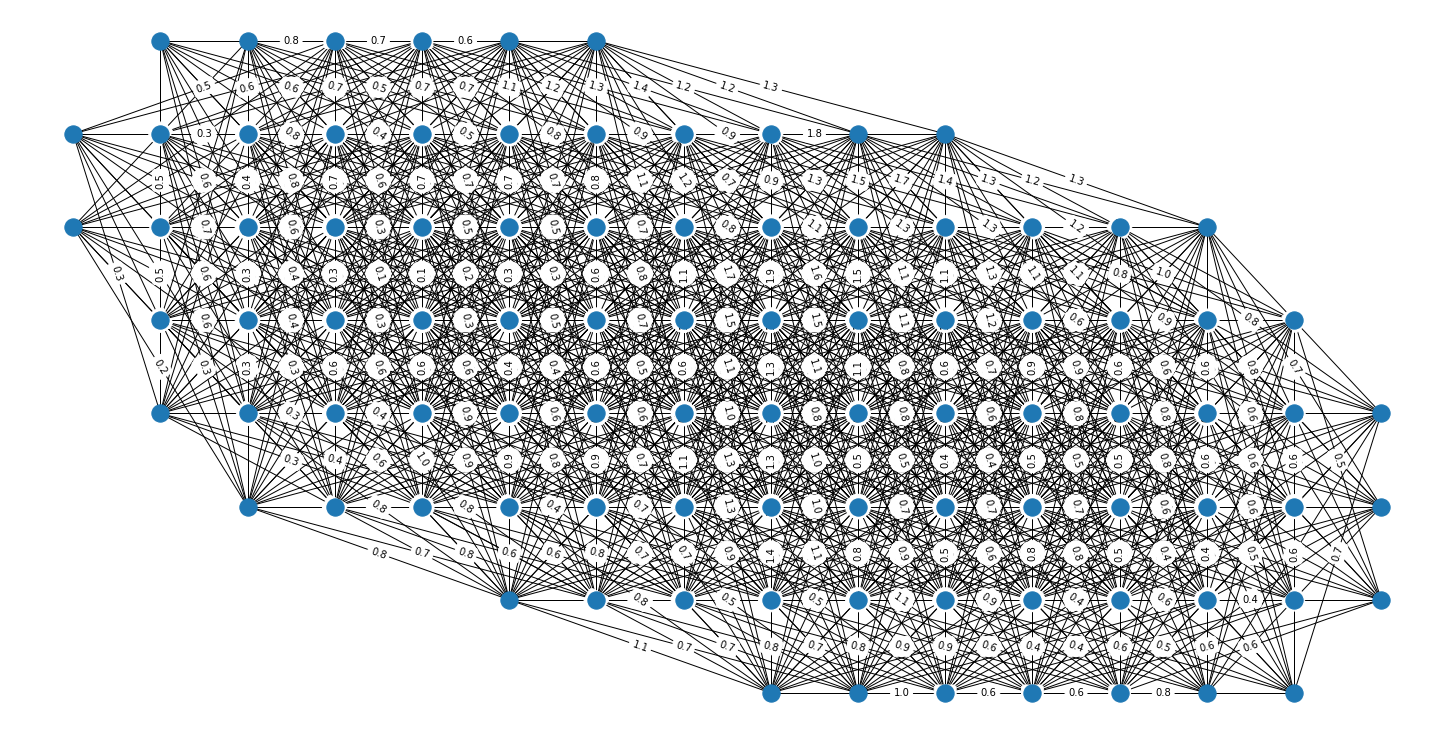

In [29]:
def plot_graph(g):
    labels = nx.get_edge_attributes(g,'weight') # returns dictionary
    pos = nx.get_node_attributes(g,'pos')
    plt.figure(figsize=(20,10))
    nx.draw(g,pos)
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
    # plt.savefig("first_graph.png")
    plt.show()
plot_graph(g)

### Run shortest path algorithm

In [247]:
first_node = 9 # node_list[0][0]
last_node = 277 # node_list[-1][0]
path = nx.bellman_ford_path(g,first_node, last_node)

### Plot path

In [251]:
path_positions = [node2pos(v, y_len) for v in path]

### Path plotting function

In [35]:
def plot_path(instance, path):
    # expand to greyscale
    expanded = np.expand_dims(instance, axis=2)
    expanded = np.tile(expanded, (1,1,3)) # overwrite instance by tiled one
    # colour nodes in path in red
    for (x,y) in path:
        expanded[x,y] = [0.9, 0.2, 0.2]
        
    plt.figure(figsize=(20,10))
    plt.imshow(expanded)
    plt.show()

## Graph Tools version

### Define nodes

In [43]:
# new version: node - pos list and pos -> node dictionary
x_len, y_len = instance_norm.shape

node_pos = [(i,j) for i in range(x_len) for j in range(y_len) if instance_corr[i,j]]
pos_node = {node_pos[i]:i for i in range(len(node_pos))}

### Define edges

In [ ]:
tic = time.time()
# inds_x, inds_y = np.where(instance_corr>0)
donut_tuples = get_half_donut(2.5,5)
edge_list = []

for n, (i, j) in enumerate(node_pos):
    # n is the name of the node in the graph (=index), (i,j) the position
    weight_node = 1-instance_norm[i,j]
    for (x,y) in donut_tuples:
        new_x = i+x
        new_y = j+y
        if new_x>=0 and new_x<x_len and new_y>=0 and new_y<y_len and instance_corr[new_x,new_y]: # inside corridor
            weight = 1-instance_norm[new_x, new_y]+weight_node
            edge_list.append([n, pos_node[(new_x,new_y)], round(weight,3)])
            
print(time.time()-tic)

### Add nodes and edges to graph

In [27]:
G = Graph(directed=False)
weight = G.new_edge_property("float")

# add nodes to graph
vlist = G.add_vertex(len(node_pos))
print("added nodes:", len(list(vlist)))

# add edges and properties to the graph
G.add_edge_list(edge_list, eprops=[weight])
print("added edges:", len(list(G.edges())))

added nodes: 70105


### Compute shortest path

In [33]:
tic = (time.time())
source = 0
target = len(node_pos)-1
vertices_path, edges_path = shortest_path(G, G.vertex(source), G.vertex(target), weights=weight, negative_weights=True) # true for bellman ford
gt_path = [node_pos[G.vertex_index[v]] for v in vertices_path]
print("time for shortest path", time.time()-tic)

time for shortest path 0.5378081798553467


### Plot path

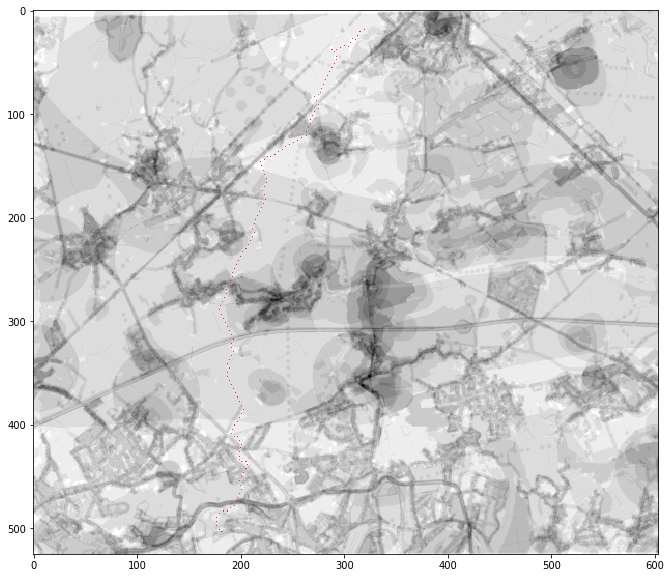

In [36]:
plot_path(instance_norm, gt_path)

# Old stuff

In [ ]:
# old version to add edges to gt graph
for edge in edge_list:
    e = G.add_edge(edge[0], edge[1])
    weight[e] = edge[2]["weight"]


In [191]:
# Old version to form edge list
edge_list = []
for i in range(x_len):
    for j in range(y_len):
        node_name = pos2node((i,j), y_len)
        if node_name in node_list_wo_attr:
            weight_node = 1-instance_norm[i,j]
            for x,y in zip(pos_x, pos_y):
                new_x = i+x
                new_y = j+y
                if new_x>=0 and new_x<x_len and new_y>=0 and new_y<y_len and instance_corr[new_x,new_y]: # inside corridor
                    weight = 1-instance_norm[new_x, new_y]+weight_node
                    edge_list.append((node_name, pos2node((new_x,new_y), y_len), {"weight": round(weight,1)}))
                    # TODO: INVERT edge weight
                    

                    
# FROM MAIN PY FILE:

tic = time.time()
# inds_x, inds_y = np.where(instance_corr>0)
donut_tuples = get_half_donut(2.5, 5)
edge_list = []
for n, (i, j) in enumerate(node_pos):
    # n is the name of the node in the graph (=index), (i,j) the position
    weight_node = 1 - instance_norm[i, j]
    for (x, y) in donut_tuples:
        new_x = i + x
        new_y = j + y
        # if inside the image at all
        if new_x >= 0 and new_x < x_len and new_y >= 0 and new_y < y_len:
            # if inside corridor
            if instance_corr[new_x, new_y]:
                weight = 1 - instance_norm[new_x, new_y] + weight_node
                edge_list.append(
                    (
                        n, pos_node[(new_x, new_y)], {
                            "weight": round(weight, 3)
                        }
                    )
                )
print("time to build edge list:", time.time() - tic)

# construct graph
tic = (time.time())
G = Graph(directed=False)
weight = G.new_edge_property("float")
vlist = G.add_vertex(len(node_pos))  # nodes: indices of node_list
print("added nodes:", len(list(vlist)))
for edge in edge_list:
    e = G.add_edge(edge[0], edge[1])
    weight[e] = edge[2]["weight"]
print("time to build up the graph:", time.time() - tic)

# get shortest path
tic = (time.time())
SOURCE = 0
TARGET = len(node_pos) - 1
vertices_path, edges_path = shortest_path(
    G,
    G.vertex(SOURCE),
    G.vertex(TARGET),
    weights=weight,
    negative_weights=True
)  # true for bellman ford
path = [node_pos[G.vertex_index[v]] for v in vertices_path]
print("time for shortest path", time.time() - tic)

# new version: node - pos list and pos -> node dictionary